In [1]:
import tensorflow as tf
%pylab inline
import pickle

import itertools
import os
import pandas as pd

import networkx as nx
import umap
from scipy import stats

# %env CUDA_VISIBLE_DEVICES=0

Populating the interactive namespace from numpy and matplotlib


In [2]:
tf.config.threading.set_intra_op_parallelism_threads(36)
tf.config.threading.set_inter_op_parallelism_threads(36)

In [3]:
# gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#     try:
#     # Currently, memory growth needs to be the same across GPUs
#         for gpu in gpus:
#             tf.config.experimental.set_memory_growth(gpu, True)
#         logical_gpus = tf.config.experimental.list_logical_devices('GPU')
#         print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
#     except RuntimeError as e:
#     # Memory growth must be set before GPUs have been initialized
#         print(e)

In [4]:
import hosgns
from utils import *

In [5]:
# preprocess dataset
dataset = 'LyonSchool'
AGGR_TIME = 10*60
partial_times, s_temp_net, df_tnet = load_temp_data(dataset, AGGR_TIME)

In [6]:
# rename nodes and time slices
map_node_index = {node:index for index, node in \
                  enumerate(np.unique(s_temp_net.reset_index()[['i', 'j']].values.flatten()))}
map_time_index = {time:index for index, time in \
                  enumerate(np.unique(s_temp_net.reset_index().tslice.values))}
NR_NODES = len(map_node_index)
NR_TIMES = len(map_time_index)

df_tnet['tslice'] = df_tnet['tslice'].map(map_time_index) 
df_tnet['i'] = df_tnet['i'].map(map_node_index) 
df_tnet['j'] = df_tnet['j'].map(map_node_index)

In [7]:
# load metadata
metadata = pd.read_csv('../data/metadata/metadata_%s.dat' % dataset, sep='\t', names=['node', 'label'])
metadata['node']=metadata.node.map(map_node_index)
map_node_class = dict(metadata[['node', 'label']].values)

In [9]:
# load network and default list of active nodes
supra_G = pickle.load(open('../preprocessed/SupraAdjacencyMatrix/%s/Dyn/Aggtime%dWeight1ReptimeNon.gpickle' % (dataset, AGGR_TIME), 'rb'))
pat_active_time = pickle.load(open('../preprocessed/SupraAdjacencyMatrix/%s/PatActiveTimeAggtime%d.pkl'% (dataset,AGGR_TIME), 'rb'))
node_active_time = np.array([str(map_node_index[int(n_node.split('-')[0])])+'-'+\
                                 str(map_time_index[int(n_node.split('-')[1])]) for n_node in pat_active_time])
times = [int(x.split('-')[1]) for x in node_active_time]
node_tuple_time = [(int(n_node.split('-')[0]), int(n_node.split('-')[1])) for n_node in node_active_time]

In [10]:
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.utils.extmath import cartesian

# TENSOR FACTORIZATION of 4WAY P(Dyn)

In [11]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [12]:
# load probability tensors
Pijkl = pickle.load(open('../preprocessed/SupraAdjacencyTensorSparse/%s/StatDyn/Aggtime%dWeight1ReptimeNonWindow10Way4.pkl'% (dataset, AGGR_TIME), 'rb'))
Pi = pickle.load(open('../preprocessed/SupraAdjacencyTensorSparse/%s/StatDyn/Aggtime%dWeight1ReptimeNonWindow10Way4_V.pkl'% (dataset, AGGR_TIME), 'rb')).todense()
Pj = pickle.load(open('../preprocessed/SupraAdjacencyTensorSparse/%s/StatDyn/Aggtime%dWeight1ReptimeNonWindow10Way4_Z.pkl'% (dataset, AGGR_TIME), 'rb')).todense()
Pk = pickle.load(open('../preprocessed/SupraAdjacencyTensorSparse/%s/StatDyn/Aggtime%dWeight1ReptimeNonWindow10Way4_W.pkl'% (dataset, AGGR_TIME), 'rb')).todense()
Pl = pickle.load(open('../preprocessed/SupraAdjacencyTensorSparse/%s/StatDyn/Aggtime%dWeight1ReptimeNonWindow10Way4_T.pkl'% (dataset, AGGR_TIME), 'rb')).todense()

In [13]:
Pij=Pijkl.reshape((NR_NODES*NR_TIMES*NR_NODES, NR_TIMES))

In [14]:
# compute indices of active evets for Pij rows
Pijk = Pijkl.sum(axis=-1)
ijk_prod_df = pd.DataFrame(cartesian((np.arange(NR_NODES), np.arange(NR_TIMES), np.arange(NR_NODES))), columns =['n', 't', 'c'])
ijk_df = pd.DataFrame(Pijk.coords.T[:,:3].astype(np.int32), columns=['n', 't', 'c'])
active_events_list = ijk_prod_df.reset_index().merge(ijk_df, on=['n','t','c']).loc[:, 'index'].values

In [15]:
print_every=200
solver = hosgns.HOSGNSSolver(tensor=Pij.tocsr(), marginals=(Pi,Pj,Pk,Pl), active_events_list=active_events_list, 
                         emb_dim=128,
                         iters=4000,
                         batch_size=50000, 
                         negative_samples=5,
                         learning_rate=tf.keras.optimizers.schedules.PolynomialDecay(0.05, 4000),
                         warmup_steps=100,
                         random_state=42)
loss = solver.train(print_loss='sg-tf', print_every=print_every)
emb_W, emb_T, emb_C, emb_S = solver.model.factors

#save embeddings
pickle.dump(list(solver.model.factors), open( '../output/%s_StatDyn_Aggtime%dWeight1ReptimeNonWindow%dWay%s.pkl' % (dataset, AGGR_TIME, 10, '4'), "wb" ), protocol=pickle.HIGHEST_PROTOCOL)

Warmup...
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Training...
step    0 - loss: 0.45095014572143555 (10.5504 seconds)
step  200 - loss: 0.10319972783327103 (33.0786 seconds)
step  400 - loss: 0.08112204819917679 (34.0558 seconds)
step  600 - loss: 0.07333697378635406 (34.6451 seconds)
step  800 - loss: 0.0692758783698082 (33.6553 seconds)
step 1000 - loss: 0.0667271539568901 (31.4478 seconds)
step 1200 - loss: 0.06492968648672104 (33.1643 seconds)
step 1400 - loss: 0.06357231736183167 (33.6789 seconds)
step 1600 - loss: 0.06249304860830307 (33.3715 seconds)
step 1800 - loss: 0.06160922721028328 (31.7950 seconds)
step 2000 - loss: 0.0608769990503788 (33.3959 seconds)
step 2200 - loss: 0.0602320060133934 (32.6085 seconds)
step 2400 - loss: 0.05964621156454086 (31.7108 seconds)
step 2600 - loss: 0.05913197994232178 (34.7188 seconds)
step 2800 - loss: 0.05864541605114937 (33.2798 seconds)
step

In [14]:
# load embeddings
emb_W, emb_T, emb_C, emb_S = pickle.load(open( '../output/%s_StatDyn_Aggtime%dWeight1ReptimeNonWindow%dWay%s.pkl' % (dataset, AGGR_TIME, 10, '4'), "rb" ))

Text(0.5, 1.0, '$ \\sum_{ijkl}| \\sigma (\\log(\\frac{p_{ijkl}}{\\kappa p_ip_jp_kp_l})) - \\sigma (m_{ijkl}) |$')

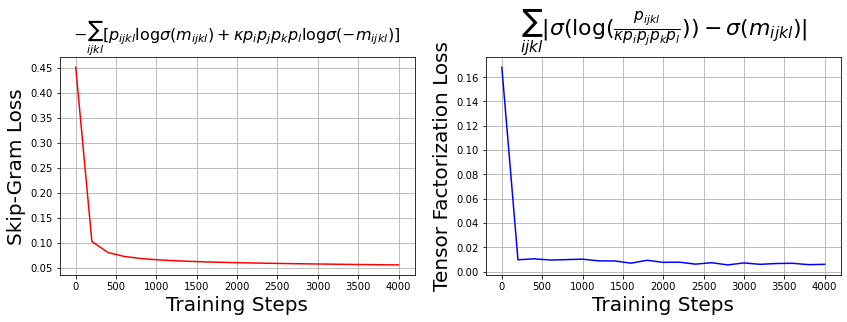

In [16]:
# plot hosgns loss function (left) and the related tensor factorization loss function (right)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))

ax[0].plot(np.arange(len(loss['sg']))*print_every, np.array([t for t in loss['sg']]) ,'r')
ax[0].grid()
ax[0].set_xlabel("Training Steps", fontsize=20)
ax[0].set_ylabel("Skip-Gram Loss", fontsize=20)
ax[0].set_title(r'$ -\sum_{ijkl}[ p_{ijkl} \log \sigma (m_{ijkl}) + \kappa p_ip_jp_kp_l \log \sigma (-m_{ijkl})]$', fontsize=16)

ax[1].plot(np.arange(len(loss['tf']))*print_every, np.array([t for t in loss['tf']]) ,'b')
# ax[1].set_yscale('log')
ax[1].grid()
ax[1].set_xlabel("Training Steps", fontsize=20)
ax[1].set_ylabel("Tensor Factorization Loss", fontsize=20)
ax[1].set_title(r'$ \sum_{ijkl}| \sigma (\log(\frac{p_{ijkl}}{\kappa p_ip_jp_kp_l})) - \sigma (m_{ijkl}) |$', fontsize=22)

In [17]:
# apply umap to embedding matrices W and T (nodes and times)
emb = umap.UMAP()
X = emb.fit_transform(emb_W.numpy())
emb = umap.UMAP()
Z = emb.fit_transform(emb_T.numpy()) 

(4.569707822799683, 17.505379724502564, -2.337449479103088, 8.367275166511536)

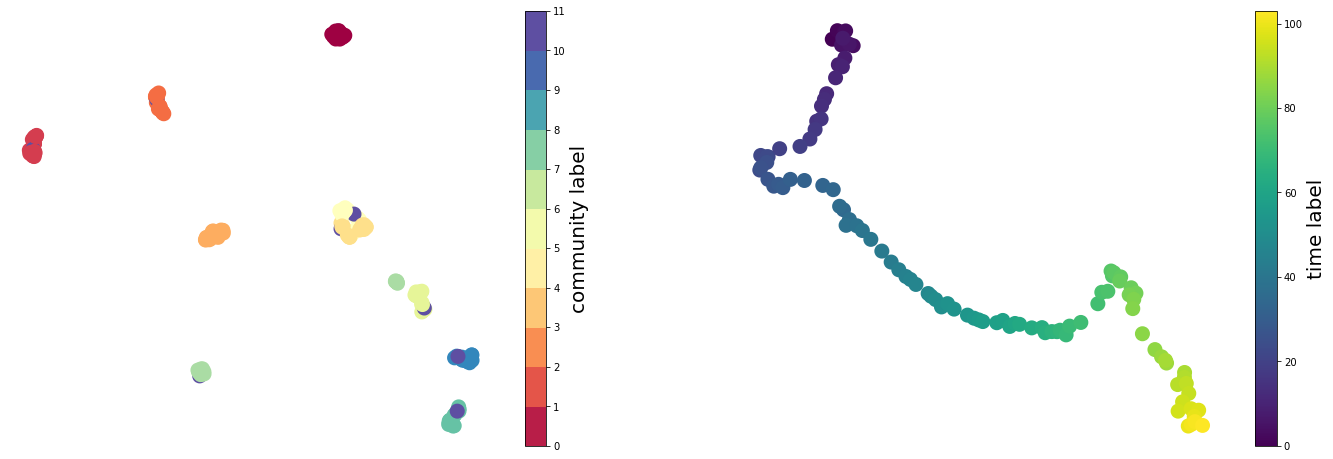

In [18]:
# plot W and T with class labels (left) and time labels (right)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(24, 8))

cb = ax[0].scatter(X[:,0], X[:,1],\
                 s=100, linewidths=5, c=get_labels(dataset, pat_active_time), cmap='Spectral')
colb = plt.colorbar(cb, ticks=np.arange(len(metadata.label.unique())+1),\
                    boundaries=np.arange(len(metadata.label.unique())+1),
                   ax=ax[0])
colb.set_label('community label', fontsize=20)
ax[0].axis('off')

cb = ax[1].scatter(Z[:,0], Z[:,1],\
                 s=100, linewidths=5, c=np.unique(times), cmap='viridis')
colb = plt.colorbar(cb, ax=ax[1])
colb.set_label('time label', fontsize=20)
ax[1].axis('off')

In [19]:
# compute hadamard product for temporal node embeddings and apply umap
emb_WdotT = np.stack([emb_W.numpy()[int(n_active.split('-')[0])]*emb_T.numpy()[int(n_active.split('-')[1])]\
                      for n_active in node_active_time])
emb = umap.UMAP()
XZ = emb.fit_transform(emb_WdotT)

(-10.234554386138916,
 27.84356508255005,
 -11.574375009536743,
 21.703638887405397)

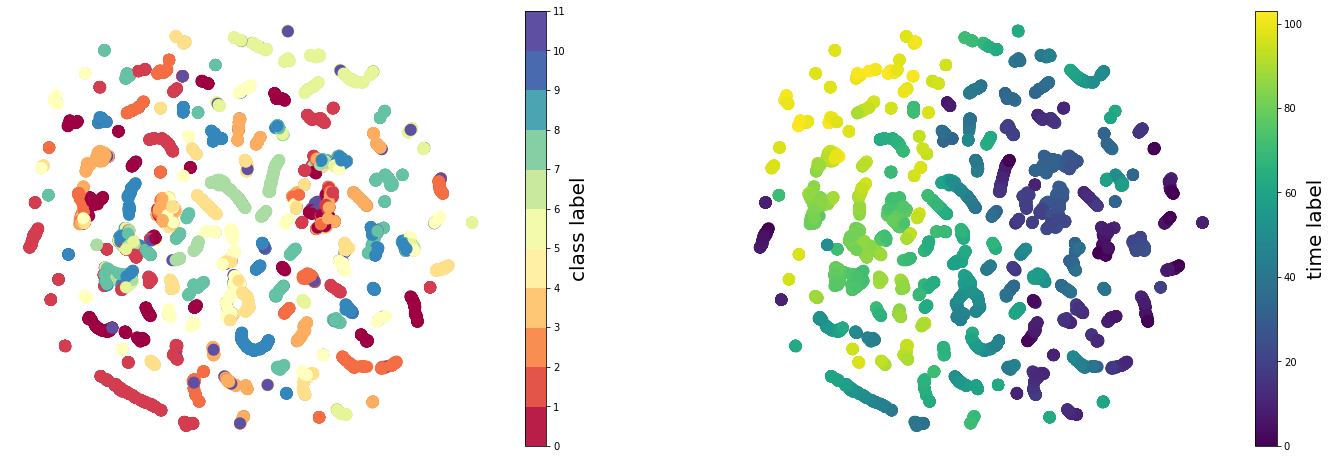

In [20]:
# plot WdotT with class labels (left) and time labels (right)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(24, 8))

cb = ax[0].scatter(XZ[:,0], XZ[:,1],\
                 s=50, linewidths=5, c=get_time_labels(dataset, pat_active_time), cmap='Spectral')
colb = plt.colorbar(cb, ticks=np.arange(len(metadata.label.unique()) +1),\
                    boundaries=np.arange(len(metadata.label.unique())+1),
                   ax=ax[0])
colb.set_label('class label', fontsize=20)
ax[0].axis('off')

cb = ax[1].scatter(XZ[:,0], XZ[:,1],\
                 s=50, linewidths=5, c=times, cmap='viridis')
colb = plt.colorbar(cb, ax=ax[1])
colb.set_label('time label', fontsize=20)
ax[1].axis('off')

## Node Classification

In [21]:
y = get_infection_label('SIR', 0.125, 0.001, pat_active_time, dataset, AGGR_TIME)
nc_res=[]
for train_test_dict in make_train_test_splits_NC(y, n_splits=30, starting_test_size=0.3, \
                       node_active_list=node_tuple_time, random_state=100):
    emb1_train_idx, emb2_train_idx, y_train_idx = train_test_dict['train']
    emb1_test_idx, emb2_test_idx, y_test_idx = train_test_dict['test']
    
    X_train = emb_W.numpy()[emb1_train_idx]*emb_T.numpy()[emb2_train_idx]
    X_test = emb_W.numpy()[emb1_test_idx]*emb_T.numpy()[emb2_test_idx]
    y_train = y[y_train_idx]
    y_test = y[y_test_idx]
    
    model_clf = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000, n_jobs=6, random_state=100))
    y_test_pred = model_clf.fit(X_train, y_train).predict(X_test)
    nc_res.append(f1_score(y_test, y_test_pred, average='macro'))
print('F1_macro:', np.mean(nc_res), '+-', np.std(nc_res))

F1_macro: 0.7439160363784446 +- 0.02867998889298773


## Link Reconstruction

In [22]:
lr_res=[]
for train_test_dict in make_train_test_splits_LR(n_splits=30, starting_test_size=0.3, \
                       node_active_list=node_tuple_time, df_events=df_tnet, random_state=100):
    emb1_train_idx, emb2_train_idx, emb3_train_idx, y_train = train_test_dict['train']
    emb1_test_idx, emb2_test_idx, emb3_test_idx, y_test = train_test_dict['test']
    X_train = emb_W.numpy()[emb1_train_idx]*emb_C.numpy()[emb2_train_idx]\
                *emb_T.numpy()[emb3_train_idx]*emb_S.numpy()[emb3_train_idx]
    X_test = emb_W.numpy()[emb1_test_idx]*emb_C.numpy()[emb2_test_idx]\
                *emb_T.numpy()[emb3_test_idx]*emb_S.numpy()[emb3_test_idx]
    
    model_clf = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000, n_jobs=6, random_state=100))
    y_test_pred = model_clf.fit(X_train, y_train).predict(X_test)
    lr_res.append(f1_score(y_test, y_test_pred, average='macro'))
print('F1_macro:', np.mean(lr_res), '+-', np.std(lr_res))

F1_macro: 0.9112169083832681 +- 0.011387521594215463


## PMI Approximation 

In [27]:
tuples = Pijkl.coords.T
samp = np.random.choice(tuples.shape[0], size=1000000, replace=False)
tuples = tuples[samp]

In [28]:
M_hat = np.sum(emb_W.numpy()[tuples[:,0]] * emb_T.numpy()[tuples[:,1]] * emb_C.numpy()[tuples[:,2]]* emb_S.numpy()[tuples[:,3]], axis=1)

In [29]:
PMI_np = np.log(Pijkl.data[samp] / (Pi[tuples[:,0]] * Pj[tuples[:,1]] * Pk[tuples[:,2]] * Pl[tuples[:,3]]))

r^2 :  0.6850712054982786


Text(0, 0.5, 'pointwise mutual information')

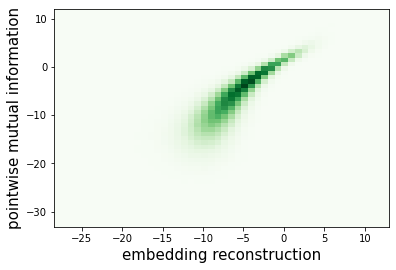

In [38]:
print('r^2 : ' ,stats.pearsonr(M_hat, PMI_np)[0]**2)
plt.hist2d(M_hat, PMI_np, bins=(50,50), cmap='Greens')
plt.xlabel('embedding reconstruction', fontsize=15)
plt.ylabel('pointwise mutual information', fontsize=15)

## Link Prediction

In [40]:
# load probability tensors
Pijkl = pickle.load(open('../preprocessed/SupraAdjacencyTensorSparse/%s/StatDyn/Aggtime%dWeight1ReptimeNonWindow10Way4.pkl'% (dataset+'_7030_0', AGGR_TIME), 'rb'))
Pi = pickle.load(open('../preprocessed/SupraAdjacencyTensorSparse/%s/StatDyn/Aggtime%dWeight1ReptimeNonWindow10Way4_V.pkl'% (dataset+'_7030_0', AGGR_TIME), 'rb')).todense()
Pj = pickle.load(open('../preprocessed/SupraAdjacencyTensorSparse/%s/StatDyn/Aggtime%dWeight1ReptimeNonWindow10Way4_Z.pkl'% (dataset+'_7030_0', AGGR_TIME), 'rb')).todense()
Pk = pickle.load(open('../preprocessed/SupraAdjacencyTensorSparse/%s/StatDyn/Aggtime%dWeight1ReptimeNonWindow10Way4_W.pkl'% (dataset+'_7030_0', AGGR_TIME), 'rb')).todense()
Pl = pickle.load(open('../preprocessed/SupraAdjacencyTensorSparse/%s/StatDyn/Aggtime%dWeight1ReptimeNonWindow10Way4_T.pkl'% (dataset+'_7030_0', AGGR_TIME), 'rb')).todense()

In [41]:
Pij=Pijkl.reshape((NR_NODES*NR_TIMES*NR_NODES, NR_TIMES))

In [42]:
# compute indices of active evets for Pij rows
Pijk = Pijkl.sum(axis=-1)
ijk_prod_df = pd.DataFrame(cartesian((np.arange(NR_NODES), np.arange(NR_TIMES), np.arange(NR_NODES))), columns =['n', 't', 'c'])
ijk_df = pd.DataFrame(Pijk.coords.T[:,:3].astype(np.int32), columns=['n', 't', 'c'])
active_events_list = ijk_prod_df.reset_index().merge(ijk_df, on=['n','t','c']).loc[:, 'index'].values

In [43]:
print_every=200
solver = hosgns.HOSGNSSolver(tensor=Pij.tocsr(), marginals=(Pi,Pj,Pk,Pl), active_events_list=active_events_list, 
                         emb_dim=128,
                         iters=4000,
                         batch_size=50000, 
                         negative_samples=5,
                         learning_rate=tf.keras.optimizers.schedules.PolynomialDecay(0.05, 4000),
                         warmup_steps=100,
                         random_state=42)
loss = solver.train(print_loss='sg-tf', print_every=print_every)
emb_W, emb_T, emb_C, emb_S = solver.model.factors

Warmup...
Training...
step    0 - loss: 0.4508788585662842 (10.2846 seconds)
step  200 - loss: 0.10273170471191406 (33.3080 seconds)
step  400 - loss: 0.08072851598262787 (33.7638 seconds)
step  600 - loss: 0.07288529723882675 (33.1520 seconds)
step  800 - loss: 0.06881062686443329 (34.7488 seconds)
step 1000 - loss: 0.0662165954709053 (33.5602 seconds)
step 1200 - loss: 0.06439194828271866 (32.2004 seconds)
step 1400 - loss: 0.06300599873065948 (32.1568 seconds)
step 1600 - loss: 0.06193070858716965 (34.2474 seconds)
step 1800 - loss: 0.06102626398205757 (33.3317 seconds)
step 2000 - loss: 0.06027252599596977 (32.1561 seconds)
step 2200 - loss: 0.05961018055677414 (32.2504 seconds)
step 2400 - loss: 0.059011247009038925 (32.7367 seconds)
step 2600 - loss: 0.0584854818880558 (32.7995 seconds)
step 2800 - loss: 0.05799335613846779 (32.6445 seconds)
step 3000 - loss: 0.0575522780418396 (33.9429 seconds)
step 3200 - loss: 0.057131242007017136 (32.8805 seconds)
step 3400 - loss: 0.05674113

In [44]:
_, _, df_tnet = load_temp_data(dataset)
_, _, df_samp = load_modified_temp_data(dataset)
df_del = df_tnet.loc[df_tnet.merge(df_samp, on=['tslice','i','j'], how='left', suffixes=('','_')).weight_.isnull()].reset_index(drop=True)

df_samp['tslice'] = df_samp['tslice'].map(map_time_index) 
df_samp['i'] = df_samp['i'].map(map_node_index) 
df_samp['j'] = df_samp['j'].map(map_node_index)

df_del['tslice'] = df_del['tslice'].map(map_time_index) 
df_del['i'] = df_del['i'].map(map_node_index) 
df_del['j'] = df_del['j'].map(map_node_index)

In [45]:
df_events = (df_samp, df_del)

lp_res=[]
for train_test_dict in make_train_test_splits_LP(n_splits=30, starting_test_size=0.3, \
                       node_active_list=node_tuple_time, df_events=df_events, random_state=100):
    emb1_train_idx, emb2_train_idx, emb3_train_idx, y_train = train_test_dict['train']
    emb1_test_idx, emb2_test_idx, emb3_test_idx, y_test = train_test_dict['test']
    X_train = emb_W.numpy()[emb1_train_idx]*emb_C.numpy()[emb2_train_idx]\
                *emb_T.numpy()[emb3_train_idx]*emb_S.numpy()[emb3_train_idx]
    X_test = emb_W.numpy()[emb1_test_idx]*emb_C.numpy()[emb2_test_idx]\
                *emb_T.numpy()[emb3_test_idx]*emb_S.numpy()[emb3_test_idx]
    
    model_clf = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000, n_jobs=6, random_state=100))
    y_test_pred = model_clf.fit(X_train, y_train).predict(X_test)
    lp_res.append(f1_score(y_test, y_test_pred, average='macro'))
print('F1_macro:', np.mean(lp_res), '+-', np.std(lp_res))

F1_macro: 0.906454408762654 +- 0.015035987118413032
